<a href="https://colab.research.google.com/github/Ziqi-Li/GEO4162C/blob/main/notebooks/p_median.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spatial Optimization (1): p-Median  Problem

This problem entails the location of p-facilities while minimizing the total weighted distance of servicing all demands.
Each node has an associated weight that represents the amount of demand at that node.


**Objective function:** Minimizing demand-weighted  summed over all facilities and demand nodes.

**Decision variables:** where to put the facilities and which demand nodes are serviced by which facility location

**Constraints:**
- Each node is serviced by 1 facility
- A node can be serviced by a facility at a certain location only if there is a facility.
- We must place p facilities
- Each node is either a facility or not.

In [22]:
pip install -q pulp

In [23]:
from pulp import *
import numpy as np
import geopandas as gp
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [24]:
#read a sample shapefile
georgia_shp = gp.read_file("https://raw.githubusercontent.com/Ziqi-Li/GEO4162C/main/data/georgia/G_utm.shp")

In [25]:
georgia_shp.shape

(172, 18)

In [26]:
#create a demand and a facilities variable, indicating the indices of each demand and facility.
#demand node: all counties
#facility: Facilities will be built on top of some chosen counties

demand = np.arange(0,172,1)
facilities = np.arange(0,172,1)

In [27]:
#Calculate a distance matrix d_ij (n by n)
coords = list(zip(georgia_shp.centroid.x,georgia_shp.centroid.y))

d = cdist(coords,coords)

In [28]:
#the demand for each county (h_i) is the total populatoion
h = georgia_shp.TotPop90.values

In [29]:
# declare facilities variables;the resulting variable names are: X_1,X_2,...
X = LpVariable.dicts('X_%s',(facilities),cat='Binary')

# declare demand-facility pair variables; the resulting variable names are Y_0_1, Y_0_2,...
Y = LpVariable.dicts('Y_%s_%s', (demand,facilities),cat='Binary')

In [30]:
#Number of facilities to place
p = 3 #change this and re-run the code.

#Create a new problem
prob = LpProblem('P_Median', LpMinimize)

In [31]:
# Objective function: Minimizing weighted demand-distance  summed over all facilities and demand nodes
# (h_i: demand at i; d_ij: distance between i and j)
# A "for" loop is used for iterating over a sequence

prob += sum(sum(h[i] * d[i][j] * Y[i][j] for j in facilities) for i in demand)

In [32]:
# This constraint indicates we must place exactly p facilities

prob += sum([X[j] for j in facilities]) == p

In [33]:
# This constraint implies that a demand node i can only be serviced by one facility

for i in demand:
    prob += sum(Y[i][j] for j in facilities) == 1

In [34]:
# This constraint implies that that demand node i
# can be serviced by a facility at j only if there is a facility at j
# It implicitly removes situation when X[j] = 0 but Y[i][j] = 1
# (node i is served by j but there is no facility at j)

for i in demand:
    for j in facilities:
        prob +=  Y[i][j] <= X[j]

In [35]:
%%time

# Solve the above problem
prob.solve()

print("Status:", LpStatus[prob.status])

Status: Optimal
CPU times: user 1.35 s, sys: 64 ms, total: 1.42 s
Wall time: 11.5 s


In [36]:
# The minimized total demand-distance. The unit is person * meter (total distance travelled)
print("Objective: ",value(prob.objective))

Objective:  469538765110.4489


In [37]:
# Print the facility node.
rslt=[]
for v in prob.variables():
    subV = v.name.split('_')

    if subV[0] == "X" and v.varValue == 1:
        rslt.append(int(subV[1]))
        print('Facility Node: ', subV[1])

Facility Node:  126
Facility Node:  30
Facility Node:  82


In [38]:
# Get the geomerty of the facility nodes.
fac_loc = georgia_shp.iloc[rslt,:]

In [39]:
fac_loc

,AREA,PERIMETER,G_UTM_,G_UTM_ID,AREANAME,Latitude,Longitud,TotPop90,PctRural,PctBach,PctEld,PctFB,PctPov,PctBlack,X,Y,AreaKey,geometry
126,7.315030e+08,117190.0,130,128,"GA, Crisp County",31.92540,-83.77159,20011,48.4,10.0,12.47,0.30,29.0,40.66,805648.4,3537103,13081,"POLYGON ((787012.250 3547615.750, 820243.312 3..."
30,1.385270e+09,274218.0,32,31,"GA, Fulton County",33.78940,-84.46716,648951,4.2,31.6,9.63,4.13,18.4,49.92,733728.4,3733248,13121,"POLYGON ((752606.688 3785970.500, 752835.062 3..."
82,9.179670e+08,121744.0,84,84,"GA, Jenkins County",32.78866,-81.96042,8247,53.8,7.7,13.10,0.21,27.8,41.51,970465.7,3640263,13165,"POLYGON ((989566.750 3653155.750, 981378.062 3..."


<Axes: >

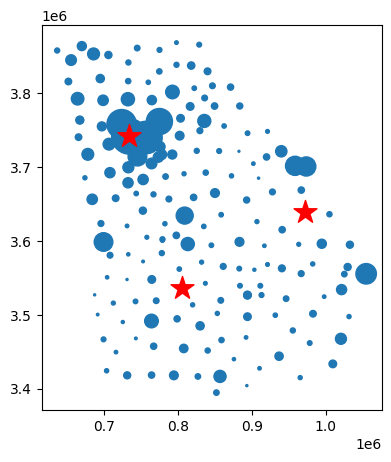

In [40]:
#Plot the faclities (stars) on top of the demand map.
fig, ax = plt.subplots(figsize=(5,5))

georgia_shp.centroid.plot(ax=ax,markersize=georgia_shp.TotPop90/1000)#markersize is proportional to the population
fac_loc.centroid.plot(ax=ax,color="red",markersize=300,marker="*")